# Задание

1) Натренировать нейронную сеть, отличающую классы bicycle, motorcycle, background (всё, что не велосипед и не мотоцикл). (6 баллов)
    * Можно использовать претренированную модель, но нужно ее дообучить.
    * Не должно быть багов (обратите внимание на дисбаланс классов).
2) Провести анализ результатов (confusion матрица, зависимость точности от внешних условий, сравнение моделей, анализ метрик, ...). (1-2 балла в зависимости от полноты анализа)
3) Сравнить производительность в разных рантаймах: onnxruntime, tensorrt, tvm, tflite, pytorch-keras, openvino... (0.5 балла за каждый фреймворк)
4) Продемонстрировать манипуляцию весами: трансформировать первый слой, чтобы количество входных каналов в первой свертке было не 3, а 1 с минимальной потерей точности. То есть, сетка должна работать на грейскейле. (1 балл)

## Настройки/Гиперпараметры/Импорты

In [1]:
import numpy as np
import random
import pickle
from tqdm import tqdm

import torchvision
import torch
from transformers import ViTForImageClassification, ViTImageProcessor

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import time

c:\Users\user\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\user\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dtype = torch.float32
device = torch.device("cpu")
models_path = "./models/"
data_path = "./data/"
loss_path = "./losses/"

num_classes = 3
epochs = 5
learning_rate = 0.0001

runs = 100

In [3]:
classes = ["apple",  "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]
for i in range (len(classes)):
    print(f"Класс {i}: {classes[i]}")

Класс 0: apple
Класс 1: aquarium_fish
Класс 2: baby
Класс 3: bear
Класс 4: beaver
Класс 5: bed
Класс 6: bee
Класс 7: beetle
Класс 8: bicycle
Класс 9: bottle
Класс 10: bowl
Класс 11: boy
Класс 12: bridge
Класс 13: bus
Класс 14: butterfly
Класс 15: camel
Класс 16: can
Класс 17: castle
Класс 18: caterpillar
Класс 19: cattle
Класс 20: chair
Класс 21: chimpanzee
Класс 22: clock
Класс 23: cloud
Класс 24: cockroach
Класс 25: couch
Класс 26: crab
Класс 27: crocodile
Класс 28: cup
Класс 29: dinosaur
Класс 30: dolphin
Класс 31: elephant
Класс 32: flatfish
Класс 33: forest
Класс 34: fox
Класс 35: girl
Класс 36: hamster
Класс 37: house
Класс 38: kangaroo
Класс 39: keyboard
Класс 40: lamp
Класс 41: lawn_mower
Класс 42: leopard
Класс 43: lion
Класс 44: lizard
Класс 45: lobster
Класс 46: man
Класс 47: maple_tree
Класс 48: motorcycle
Класс 49: mountain
Класс 50: mouse
Класс 51: mushroom
Класс 52: oak_tree
Класс 53: orange
Класс 54: orchid
Класс 55: otter
Класс 56: palm_tree
Класс 57: pear
Класс 58: pi

In [5]:
data_train = torchvision.datasets.CIFAR100(root=data_path,
                                           train=True,
                                           download=True,
                                          )

# датасет для тестирования
data_test = torchvision.datasets.CIFAR100(root=data_path,
                                          train=False,
                                          download=True,
                                         )

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = ViTForImageClassification.from_pretrained('edumunozsala/vit_base-224-in21k-ft-cifar100')

In [7]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [8]:
ViTImageProcessor.preprocess.__defaults__

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 <ChannelDimension.FIRST: 'channels_first'>,
 None)

In [9]:
ViTImageProcessor.preprocess.__defaults__ = (None, None, None, None, None, None, None, None, "pt", ViTImageProcessor.preprocess.__defaults__[9], None)
ViTImageProcessor.preprocess.__defaults__

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 'pt',
 <ChannelDimension.FIRST: 'channels_first'>,
 None)

In [10]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

In [11]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
data_test = torchvision.datasets.CIFAR100(root=data_path,
                                          train=False,
                                          download=True,
                                          transform=feature_extractor
                                         )

loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size=20,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True
                                         )

Files already downloaded and verified


In [13]:
def model_predict(model, loader, device, finetuned=False) -> tuple:
    labels_true = []
    labels_pred = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            for t in target:
                labels_true.append(t)

            if finetuned:
                data["pixel_values"] = data["pixel_values"][:,0].to(device)
            else:
                data["pixel_values"] = data["pixel_values"][0].to(device)
            preds = model(**data)
            preds = torch.argmax(preds.logits, axis=-1)
            preds = preds.to("cpu")
            for pred in preds:
                labels_pred.append(pred)

    return labels_true, labels_pred

In [14]:
def print_confusion_matrix(confusion_matrix_full: np.ndarray) -> None:
    confusion_matrix_ = np.zeros(shape=(3,3))
    confusion_matrix_[0][0] = confusion_matrix_full[8][8]
    confusion_matrix_[0][1] = confusion_matrix_full[8][48]
    confusion_matrix_[0][2] = confusion_matrix_full[8].sum() - confusion_matrix_[0][0] - confusion_matrix_[0][1]

    confusion_matrix_[1][0] = confusion_matrix_full[48][8]
    confusion_matrix_[1][1] = confusion_matrix_full[48][48]
    confusion_matrix_[1][2] = confusion_matrix_full[48].sum() - confusion_matrix_[1][0] - confusion_matrix_[1][1]


    confusion_matrix_[2][0] = confusion_matrix_full.sum(axis=0)[8] - confusion_matrix_[0][0] - confusion_matrix_[1][0] 
    confusion_matrix_[2][1] = confusion_matrix_full.sum(axis=0)[48] - confusion_matrix_[0][1] - confusion_matrix_[1][1]
    confusion_matrix_[2][2] = confusion_matrix_full.sum() - confusion_matrix_.sum()

    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ["Bicycle", "Motorcycle", "Background"]).plot()

In [18]:
confusion_matrix_downloaded_full = confusion_matrix(*model_predict(model=model, loader=loader_test, device=device))

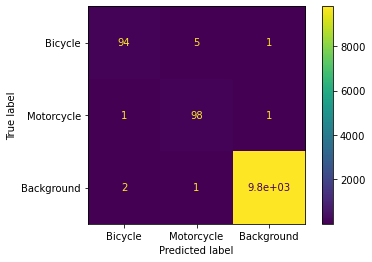

In [19]:
print_confusion_matrix(confusion_matrix_full=confusion_matrix_downloaded_full)

* Для класса Bicycle 94 элемента были выявлены правильно, 5 были предсказаны как Motorcycle и 1 как Background.
* Для класса Motorcycle 98 элементов были предсказаны правильно, 1 был предсказан как Bicycle и 1 как Background.
* Для класса Background почти все элементы~10000 были предсказаны "правильно", только 2 были помечены как Bicycle и 1 как Motorcycle.

In [15]:
def model_train(model, epochs: np.int64, loader, loss_func, optimizer, num_classes: np.int64, device) -> list:
    model.to(device) 
    model.train() 

    losses = [0.0] * epochs
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            p_true = torch.zeros(size=(loader.batch_size, num_classes), device=device)
            for batch, t in enumerate(target):
                p_true[batch][t] = 1.0
            data["pixel_values"] = data["pixel_values"][:,0].to(device)
            p_pred = model(**data) 
            p_pred = p_pred.logits

            loss = loss_func(p_pred, p_true)
            losses[epoch] += loss/len(loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"loss on epoch {epoch+1}:\t {losses[epoch]}")
    return losses

In [16]:
data_train = torchvision.datasets.CIFAR100(root=data_path,
                                           train=True,
                                           download=True,
                                           transform=feature_extractor
                                          )

Files already downloaded and verified


In [17]:
samples_with_background = []
samples_with_bicycle_and_motorcycle = []
for i, sample in tqdm(enumerate(data_train)):
    if sample[1] == 8 or sample[1] == 48:
        samples_with_bicycle_and_motorcycle.append(i)
    else:
        samples_with_background.append(i)

50000it [23:27, 35.53it/s]


In [18]:
data_train_ = []

for i in samples_with_bicycle_and_motorcycle:
    data_train_.append(data_train[i])

for i in random.sample(samples_with_background, 500):
    data_train_.append(data_train[i])

data_train = data_train_

In [19]:
for i, (data, target) in enumerate(data_train):
    if target == 8:
        data_train[i] = (data_train[i][0], 0)
    elif target == 48:
        data_train[i] = (data_train[i][0], 1)
    else:
        data_train[i] = (data_train[i][0], 2)

In [20]:
#with open(data_path+"data_train_processed.pkl", 'rb') as f:
#    data_train = pickle.load(f)

In [21]:
loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=20,
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )

In [22]:
model = ViTForImageClassification.from_pretrained('edumunozsala/vit_base-224-in21k-ft-cifar100')

In [23]:
model.classifier = torch.nn.Linear(in_features=768, out_features=3, bias=True)

In [24]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [25]:
loss_function = torch.nn.CrossEntropyLoss(reduction='mean')

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
losses = model_train(model=model,
                     epochs=epochs,
                     loader=loader_train,
                     loss_func=loss_function,
                     optimizer=optimizer,
                     num_classes=num_classes,
                     device=device
                    )

loss on epoch 1:	 0.206567645072937
loss on epoch 2:	 0.08054904639720917
loss on epoch 3:	 0.027181871235370636
loss on epoch 4:	 0.06620611250400543
loss on epoch 5:	 0.03142213076353073


In [35]:
#with open(loss_path+"loss_finetuned.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#    pickle.dump(losses, f) # сохранение значения loss

In [36]:
#torch.save(model.state_dict(), models_path+"model_finetuned_state_dict.pth")
#torch.save(model, models_path+"model_finetuned.pth")

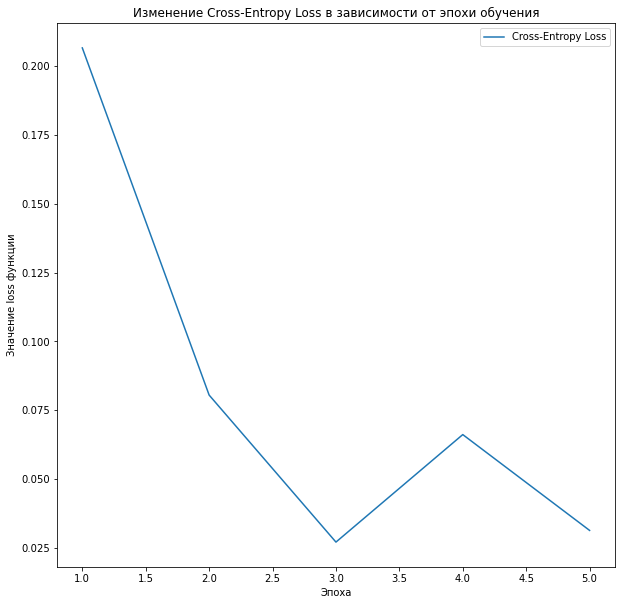

In [30]:
plt.figure(figsize=(10,10))
plt.title("Изменение Cross-Entropy Loss в зависимости от эпохи обучения")
plt.plot(range(1, epochs+1), losses, label="Cross-Entropy Loss")
plt.xlabel("Эпоха")
plt.ylabel("Значение loss функции")
plt.legend()
plt.show()

In [31]:
data_test = torchvision.datasets.CIFAR100(root=data_path,
                                          train=False,
                                          download=True,
                                          transform=feature_extractor
                                         )

Files already downloaded and verified


In [32]:
data_test_ = []

for i, (data, target) in tqdm(enumerate(data_test)):
    if target == 8:
        data_test_.append((data_test[i][0], 0))
    elif target == 48:
        data_test_.append((data_test[i][0], 1))
    else:
        data_test_.append((data_test[i][0], 2))

data_test = data_test_

10000it [10:26, 15.96it/s]


In [33]:
#with open(data_path+"data_test_processed_gray.pkl", 'wb') as f:
#    pickle.dump(data_test, f)

In [34]:
loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size=20,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True
                                         )

In [37]:
model = torch.load(models_path+"model_finetuned.pth")

In [38]:
labels_true, labels_pred = model_predict(model=model, loader=loader_test, device=device, finetuned=True)

In [40]:
#with open(models_path+"labels_true.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#    pickle.dump(labels_true, f) # сохранение обработанного обучающего датасета

In [41]:
#with open(models_path+"labels_pred.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#    pickle.dump(labels_pred, f) # сохранение обработанного обучающего датасета

In [39]:
confusion_matrix_finetuned = confusion_matrix(y_true=labels_true, y_pred=labels_pred)

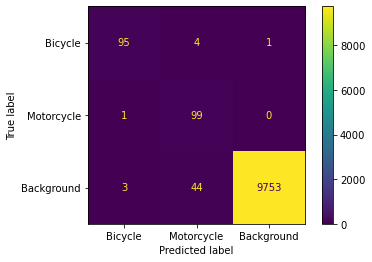

In [42]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_finetuned, display_labels=["Bicycle", "Motorcycle", "Background"]).plot()

* Модель правильно предсказала 95 элементов, 4 как Motorcycle и 1 как Background
* Motorcycle был спутан лишь единожды с классом Bicycle.
* Background в основной своей массе был предсказан правильно.

In [47]:
def model_evaluate(labels_true, labels_pred) -> dict:
    metrics = {}
    metrics["precision"] = precision_score(y_true=labels_true, y_pred=labels_pred, average="weighted")
    metrics["recall"] = recall_score(y_true=labels_true, y_pred=labels_pred, average="weighted")
    metrics["f1"] = f1_score(y_true=labels_true, y_pred=labels_pred, average="weighted")
    metrics["accuracy"] = accuracy_score(y_true=labels_true, y_pred=labels_pred)

    for metric in metrics.keys():
        print(f"Метрика '{metric}': {metrics[metric]}")

In [48]:
model_evaluate(labels_true=labels_true, labels_pred=labels_pred)

Метрика 'precision': 0.9962301818721164
Метрика 'recall': 0.9947
Метрика 'f1': 0.9951582871217998
Метрика 'accuracy': 0.9947


In [51]:
for i in tqdm(range(len(data_test))):
    gray_tensor = torchvision.transforms.functional.rgb_to_grayscale(data_test[i][0]["pixel_values"][0])
    gray_tensor = torch.unsqueeze(gray_tensor, dim=0)
    data_test[i][0]["pixel_values"] = gray_tensor

100%|██████████| 10000/10000 [00:09<00:00, 1110.39it/s]


In [52]:
#with open(data_path+"data_test_processed_gray.pkl", 'wb') as f:
#    pickle.dump(data_test, f)

In [53]:
with open(data_path+"data_test_processed_gray.pkl", 'rb') as f: # открываем файл для чтения (b - бинарной)
    data_test = pickle.load(f) # загружаем данные из файла

In [54]:
loader_test_processed_gray = torch.utils.data.DataLoader(dataset=data_test,
                                                         batch_size=20,
                                                         shuffle=True,
                                                         num_workers=2,
                                                         pin_memory=True
                                                        )

In [55]:
model = torch.load(models_path+"model_finetuned.pth")
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [56]:
state_dict = model.state_dict()
state_dict.keys()

odict_keys(['vit.embeddings.cls_token', 'vit.embeddings.position_embeddings', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.intermediate.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit.encoder.layer.0.output.dense.weight', 'vit.encoder.layer.0.output.dense.bias', 'vit.encoder.layer.0.layernorm_before.weight', 'vit.encoder.layer.0.layernorm_before.bias', 'vit.encoder.layer.0.layernorm_after.weight', 'vit.encoder.layer.0.layernorm_after.bias', 'vit.encoder.layer.1.atten

In [60]:
state_dict["vit.embeddings.patch_embeddings.projection.weight"]

tensor([[[[ 1.6759e-02,  5.2489e-02,  5.7039e-02,  ...,  8.8858e-02,
            1.0874e-01,  1.2115e-01],
          [ 1.3682e-02,  1.5135e-02,  2.1132e-02,  ...,  8.5102e-02,
            4.0004e-02,  8.7002e-02],
          [ 1.7963e-02,  1.2775e-02, -2.5041e-03,  ...,  7.7890e-02,
            3.4256e-02,  3.7094e-02],
          ...,
          [-1.3176e-02, -4.5300e-03, -5.3917e-02,  ..., -5.8315e-02,
           -6.7127e-02,  2.0736e-02],
          [ 4.0481e-02, -4.3973e-02, -2.1657e-02,  ...,  1.1658e-02,
           -3.9594e-02,  8.2445e-02],
          [ 7.0540e-02,  8.1930e-02,  3.8605e-02,  ...,  9.6274e-02,
            1.1599e-01,  1.5391e-01]],

         [[-6.2858e-02, -3.8312e-02, -4.1874e-02,  ..., -5.9272e-02,
           -2.5291e-02, -2.1048e-02],
          [-8.1944e-03, -1.0491e-02, -7.7457e-03,  ..., -3.2439e-02,
           -4.5124e-02, -1.7346e-04],
          [ 4.6273e-02,  3.3213e-02,  1.3910e-02,  ..., -3.4951e-02,
           -3.9331e-02, -3.1583e-02],
          ...,
     

In [61]:
r = state_dict["vit.embeddings.patch_embeddings.projection.weight"][:,0:1,:,:]
g = state_dict["vit.embeddings.patch_embeddings.projection.weight"][:,1:2,:,:]
b = state_dict["vit.embeddings.patch_embeddings.projection.weight"][:,2:3,:,:]

In [64]:
state_dict["vit.embeddings.patch_embeddings.projection.weight"] = 0.299*r + 0.587*g + 0.114*b

In [65]:
model.vit.embeddings.patch_embeddings.projection

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [66]:
model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(in_channels=1, out_channels=768, kernel_size=(16,16), stride=(16, 16))

In [67]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [68]:
model.config.num_channels = 1
model.vit.embeddings.patch_embeddings.num_channels = 1

In [69]:
#torch.save(model.state_dict(), models_path+"model_finetuned_state_dict_gray.pth")
#torch.save(model, models_path+"model_finetuned_gray.pth")

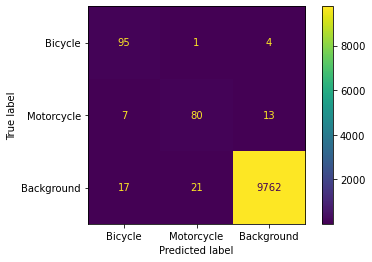

In [70]:
labels_true_gray, labels_pred_gray = model_predict(model=model, loader=loader_test_processed_gray, device=device, finetuned=True)
confusion_matrix_finetuned_gray = confusion_matrix(y_true=labels_true_gray, y_pred=labels_pred_gray)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_finetuned_gray, display_labels=["Bicycle", "Motorcycle", "Background"]).plot()

Качество предсказаний при переходе на grayscale ухудшилось, элементы из классов Motorcycle и Background стали чаще предсказываться как Bicycle.

In [71]:
#with open(models_path+"labels_true_gray.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#    pickle.dump(labels_true, f) # сохранение обработанного обучающего датасета

In [72]:
#with open(models_path+"labels_pred_gray.pkl", 'wb') as f: # открытие файла для записи (b - бинарной)
#    pickle.dump(labels_pred, f) # сохранение обработанного обучающего датасета